In [1]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

In [2]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("../input/modified-dataset/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("../input/modified-dataset/val", transform = transforms)
testset = torchvision.datasets.ImageFolder("../input/modified-dataset/test", transform = transforms)

#batches
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

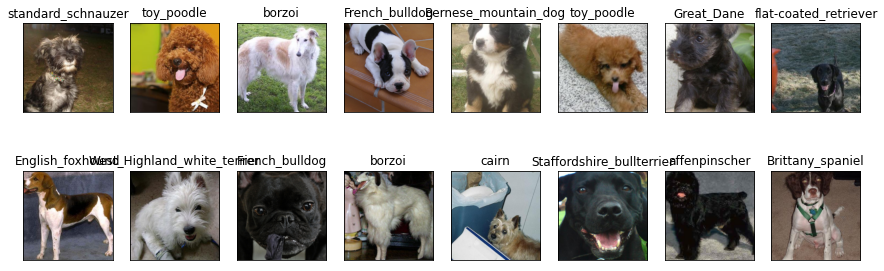

In [3]:
images, labels = iter(trainloader).next()
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])

In [4]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  113
number of validation batches :  16
Size of test batches :  33


In [5]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

Unique classes number :  120
Classes :  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_Englis

In [6]:
# Whether to train on a gpu
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')
print(f"my device: {torch.cuda.get_device_name(0)}")

Train on gpu: True
my device: Tesla T4


In [44]:
model = torchvision.models.resnet18(pretrained = True)


#freeze model params
for param in model.parameters():
    param = param.requires_grad_(False)
    
#new layer
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 512),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(512,256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, len(trainset.classes)),                   
                      nn.LogSoftmax(dim=1))

print(model.eval())
print("The new layer is : ",model.fc)
model = model.to(device) #Moving the model to GPU

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = lr)

In [9]:
#format class

class color_formats:
    """
    Simple color formating:
    Variables:
        >OKCYAN - cyan printing.
        >Bold - bold printing.
        >UNDERLINE - underline printing.
    """
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [10]:
def train_loop(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_model_name,
          max_epochs_stop=3,
          num_epochs=20,
          num_epochs_report=1):
    """Train a neural network Model
    Args
    --------
        >model (Pytorch nn model): The neural network for the training process.  
        >criterion (Pytorch loss function): Initialize the loss function.
        >optimizer (Pytorch optimizer): Use an optimizer to compute gradients to update the weights.
        >train_loader (Pytorch dataloader): training dataloader to iterate through.
        >valid_loader (Pytorch dataloader): validation dataloader used for early stopping.
        >save_model_name (str): file path to save the model state dict, file name ends with 'pt.'.
        >max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping.
        >num_epochs (int): maximum number of training epochs if the early stopping is not activated.
        >num_epochs_report (int): frequency of epochs to print training reports.
    
    outputs
    --------
        >model (PyTorch model): Trained neural networks with best weights.
        >history (DataFrame): History of train and validation loss and accuracy.
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf  

    valid_max_acc = 0
    history = []

    # Number trained epochs  (while using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'{color_formats.BOLD + color_formats.UNDERLINE}Training activated:{color_formats.ENDC}\n')

    overall_start = timer()

    # Start of loop
    for epoch in range(num_epochs):

        # Track of training and validation loss for each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set model to train
        model.train()
        
        #start timer
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Put the data in the gpu
            if my_gpu:
                data, target = data.to(device), target.to(device)

            # Remove past gradients
            optimizer.zero_grad()
            # Predicted outputs as log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target.long())
            loss.backward()

            # Update the weights
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Training progress tracker
            print(
                f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')


        # Start validation after training loops ends.
        else:
            model.epochs += 1

            # Deactivate the gradient tracking. 
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Put the data in the gpu
                    if my_gpu:
                        data, target = data.to(device), target.to(device)

                    # Predicted outputs as log probabilities
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.long())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate accuracy of validation set
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results for the num_epochs_report that was set
                if (epoch + 1) % num_epochs_report == 0:
                    print(
                        f'\n\nEpoch: {color_formats.BOLD}{epoch+1}{color_formats.ENDC} \tTraining Loss: {color_formats.BOLD}{train_loss:.4f}{color_formats.ENDC} \tValidation Loss: {color_formats.BOLD}{valid_loss:.4f}{color_formats.ENDC}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {color_formats.BOLD}{100 * train_acc:.2f}%{color_formats.ENDC}\t Validation Accuracy: {color_formats.BOLD}{100 * valid_acc:.2f}%{color_formats.ENDC}\n'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_model_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch + 1

                # Otherwise count all consecutive epochs with no improvement.
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\n\n{color_formats.OKCYAN}Early stopping activated!{color_formats.ENDC}\nthe validation loss has not improved for {max_epochs_stop} epochs.\n\n{color_formats.BOLD + color_formats.UNDERLINE}End of training report:{color_formats.ENDC}\n\n\t-Total epochs: {epoch+1} \n\t-Best epoch: {color_formats.BOLD}{best_epoch}{color_formats.ENDC} \n\t-loss: {color_formats.BOLD}{valid_loss_min:.2f}{color_formats.ENDC} \n\t-accuracy: {color_formats.BOLD}{100 * valid_best_acc:.2f}%\n{color_formats.ENDC}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_model_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # History update
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history


    # Record overall time and print out Report
    total_time = timer() - overall_start
    print(
        f'\nBest epoch is epoch #{best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # History update
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [46]:
# Start Training
# Running the model
model, history = train_loop(
    model,
    criterion,
    optimizer,
    trainloader,
    validloader,
    save_model_name="./resnet18_dog_scratch.pt",
    max_epochs_stop=20,
    num_epochs=30,
    num_epochs_report=3)

Training activated:

Epoch: 3	100.00% complete. 130.40 seconds elapsed in epoch.

Epoch: 3 	Training Loss: 1.1491 	Validation Loss: 0.8357
		Training Accuracy: 63.71%	 Validation Accuracy: 73.87%

Epoch: 6	100.00% complete. 130.55 seconds elapsed in epoch.

Epoch: 6 	Training Loss: 0.9021 	Validation Loss: 0.7228
		Training Accuracy: 71.51%	 Validation Accuracy: 77.10%

Epoch: 9	100.00% complete. 129.64 seconds elapsed in epoch.

Epoch: 9 	Training Loss: 0.7788 	Validation Loss: 0.7170
		Training Accuracy: 74.42%	 Validation Accuracy: 76.46%

Epoch: 12	100.00% complete. 131.30 seconds elapsed in epoch.

Epoch: 12 	Training Loss: 0.7084 	Validation Loss: 0.7085
		Training Accuracy: 76.62%	 Validation Accuracy: 77.35%

Epoch: 15	100.00% complete. 129.93 seconds elapsed in epoch.

Epoch: 15 	Training Loss: 0.6379 	Validation Loss: 0.7051
		Training Accuracy: 78.50%	 Validation Accuracy: 77.65%

Epoch: 18	100.00% complete. 130.84 seconds elapsed in epoch.

Epoch: 18 	Training Loss: 0.5947 

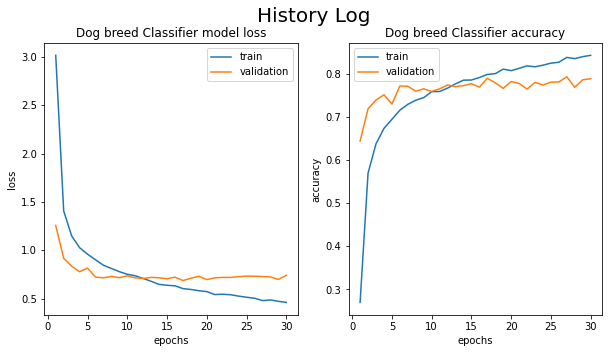

In [47]:
#models logs in detail over time of training.

history.index = [idx for idx in range(1, history.shape[0]+1)] #from first epoch
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)
#ethnicity model log

axs[0].plot(history["train_loss"], label = "train")
axs[0].plot(history["valid_loss"], label = "validation")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('Dog breed Classifier model loss')

axs[1].plot(history["train_acc"], label = "train")
axs[1].plot(history["valid_acc"], label = "validation")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('Dog breed Classifier accuracy')


plt.show()

In [48]:
def Accuracy_report(loader = None, model = None, n_classes = None):
    """
    Args:
    >loader (pytorch dataloader): the data for accuracy testing.
    >model (pytorch model) : the neural network.
    >n_classes (int): the number of classes.
    
    Output: 
    > class_acc (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
    > acc (float): overall accuracy.
    """
    my_classes = []

    classes = [n_class for n_class in range(n_classes)]
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in loader:
            inputs, targets = data 
            inputs = inputs.to(device)
            targets = targets.to(device)           
            outputs = model(inputs)    
            _, predictions = torch.max(outputs, 1)

            # collect the correct predictions for each class
            for target, prediction in zip(targets, predictions):
                if target == prediction:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    for classname, correct_count in correct_pred.items():
        try:
            accuracy = 100 * float(correct_count) / total_pred[classname]

            my_classes.append(accuracy)
        except ZeroDivisionError:
            my_classes.append(np.nan)
            continue
    
    acc =  round(100 * float(sum(correct_pred.values())/sum(total_pred.values())),2)
    class_acc = dict(zip(classes,[round(mc,2) for mc in my_classes]))
    return class_acc, acc

def test_report(class_acc,acc):
    """
    Args:
        > my_classes (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
        > acc (float): overall accuracy.
    
    Output:
        >report of test performance.
    """    
    print(f"{color_formats.BOLD + color_formats.UNDERLINE}Test Accuracy Report{color_formats.ENDC}")
    for key,value in class_acc.items():
        print(f"Class {trainset.classes[key]} has achived {color_formats.BOLD}{value}%{color_formats.ENDC} accuracy\n")
    print(f"Overall accuracy: {color_formats.BOLD}{acc}%{color_formats.ENDC}")

In [49]:
m1_test_class_acc, m1_test_acc = Accuracy_report(loader = testloader,model = model, n_classes = 120)
test_report(m1_test_class_acc,m1_test_acc)

Test Accuracy Report
Class Afghan_hound has achived 97.92% accuracy

Class African_hunting_dog has achived 100.0% accuracy

Class Airedale has achived 90.24% accuracy

Class American_Staffordshire_terrier has achived 47.06% accuracy

Class Appenzeller has achived 64.52% accuracy

Class Australian_terrier has achived 57.5% accuracy

Class Bedlington_terrier has achived 100.0% accuracy

Class Bernese_mountain_dog has achived 91.11% accuracy

Class Blenheim_spaniel has achived 94.87% accuracy

Class Border_collie has achived 86.67% accuracy

Class Border_terrier has achived 88.57% accuracy

Class Boston_bull has achived 83.78% accuracy

Class Bouvier_des_Flandres has achived 70.0% accuracy

Class Brabancon_griffon has achived 87.1% accuracy

Class Brittany_spaniel has achived 77.42% accuracy

Class Cardigan has achived 84.38% accuracy

Class Chesapeake_Bay_retriever has achived 80.0% accuracy

Class Chihuahua has achived 48.39% accuracy

Class Dandie_Dinmont has achived 94.44% accuracy

C

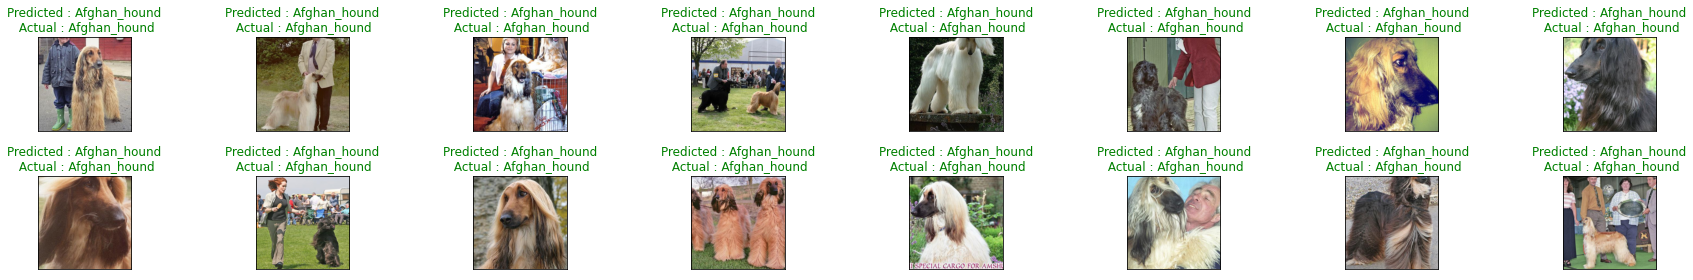

In [50]:

dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(int(batch_size/8)):
    ax = fig.add_subplot(2, int(batch_size/16), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
    ax.set_title("Predicted : {}\n Actual : {}".format(trainset.classes[preds[idx]], trainset.classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.tight_layout()

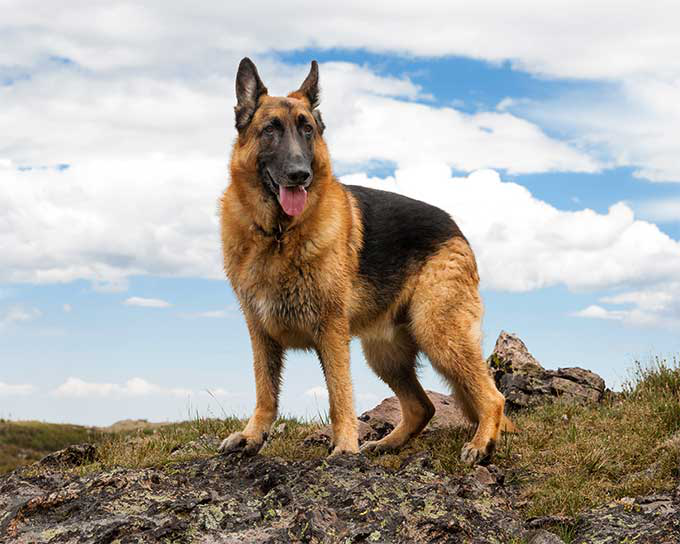

In [58]:
url = "https://dogtime.com/assets/uploads/gallery/german-shepherd-dog-breed-pictures/standing-7.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [59]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


def predictor(img, n=5):
    """
    Args: 
        >img - the image to predict.
        >n - number of top probabilities.
    
    Outputs:
        >pred - the top prediction.
        > top preds - top n predictions.
    """
    #transform the image
    img = transforms(img)
    # get the class predicted 
    pred = int(np.squeeze(model(img.unsqueeze(0).cuda()).data.max(1, keepdim=True)[1].cpu().numpy()))
    # the number is also the index for the class label
    pred = trainset.classes[pred]
    # get model log probabilities
    preds = torch.from_numpy(np.squeeze(model(img.unsqueeze(0).cuda()).data.cpu().numpy()))
    # convert to prediction probabilities of the top n predictions
    top_preds = torch.topk(torch.exp(preds),n)
    #display at an orgenized fasion
    top_preds = dict(zip([trainset.classes[i] for i in top_preds.indices],[f"{round(float(i)*100,2)}%" for i in top_preds.values]))
    return pred, top_preds

In [60]:
my_prediction, top_predictions = predictor(img, n=5)
print(my_prediction)

German_shepherd


In [61]:
torch.save(model,"resnet18_dog_scratch.pb")

In [ ]:
fetch_model=torch.load('../input/resnet18/resnet18_dog_scratch.pb')

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


def predictor(img, n=5):
    """
    Args: 
        >img - the image to predict.
        >n - number of top probabilities.
    
    Outputs:
        >pred - the top prediction.
        > top preds - top n predictions.
    """
    #transform the image
    img = transforms(img)
    # get the class predicted 
    pred = int(np.squeeze(fetch_model(img.unsqueeze(0).cuda()).data.max(1, keepdim=True)[1].cpu().numpy()))
    # the number is also the index for the class label
    pred = trainset.classes[pred]
    # get model log probabilities
    preds = torch.from_numpy(np.squeeze(fetch_model(img.unsqueeze(0).cuda()).data.cpu().numpy()))
    # convert to prediction probabilities of the top n predictions
    top_preds = torch.topk(torch.exp(preds),n)
    #display at an orgenized fasion
    top_preds = dict(zip([trainset.classes[i] for i in top_preds.indices],[f"{round(float(i)*100,2)}%" for i in top_preds.values]))
    return pred, top_preds

In [ ]:
my_prediction, top_predictions = predictor(img, n=5)
print(my_prediction)

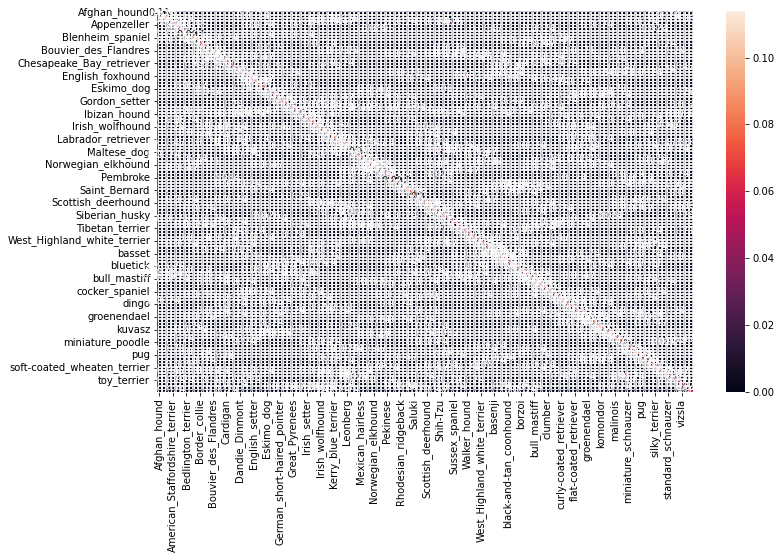

In [62]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []


# iterate over test data
for images, labels in testloader:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = trainset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('./confusion_resnet18.png')

In [63]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=trainset.classes))

Overall Accuracy:  76.9  %
                                precision    recall  f1-score   support

                  Afghan_hound       0.96      1.00      0.98        48
           African_hunting_dog       0.94      0.94      0.94        35
                      Airedale       0.69      0.88      0.77        41
American_Staffordshire_terrier       0.70      0.47      0.56        34
                   Appenzeller       0.60      0.58      0.59        31
            Australian_terrier       0.71      0.55      0.62        40
            Bedlington_terrier       0.95      0.97      0.96        37
          Bernese_mountain_dog       0.76      0.91      0.83        45
              Blenheim_spaniel       0.90      0.95      0.92        39
                 Border_collie       0.72      0.87      0.79        30
                Border_terrier       0.83      0.86      0.85        35
                   Boston_bull       0.68      0.76      0.72        37
          Bouvier_des_Flandres      

In [64]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [65]:
#ROC_AUC score
roc_auc_dict = roc_auc_score_multiclass(y_true, y_pred)
final_roc_auc_dictionary=dict(zip(list(trainset.classes) ,list(roc_auc_dict.values())) )
final_roc_auc_dictionary

{'Afghan_hound': 0.9997599039615847,
 'African_hunting_dog': 0.971189222457772,
 'Airedale': 0.9371068447021957,
 'American_Staffordshire_terrier': 0.7344565967090354,
 'Appenzeller': 0.788887860415606,
 'Australian_terrier': 0.7739216391085549,
 'Bedlington_terrier': 0.986247022884954,
 'Bernese_mountain_dog': 0.9539960545958627,
 'Blenheim_spaniel': 0.9738798176747386,
 'Border_collie': 0.9321380189656546,
 'Border_terrier': 0.9278533816590303,
 'Boston_bull': 0.8768218649684167,
 'Bouvier_des_Flandres': 0.8321380189656545,
 'Brabancon_griffon': 0.9188765986331591,
 'Brittany_spaniel': 0.8863794140787707,
 'Cardigan': 0.9046953480028701,
 'Chesapeake_Bay_retriever': 0.927135334746632,
 'Chihuahua': 0.7737153083105783,
 'Dandie_Dinmont': 0.9855125954300004,
 'Doberman': 0.8161885409195953,
 'English_foxhound': 0.7568580542264752,
 'English_setter': 0.8928628389154705,
 'English_springer': 0.9380781499202552,
 'EntleBucher': 0.8895248228608844,
 'Eskimo_dog': 0.7809427045979759,
 'Fren